# Book-Crossing Recommendation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the seed to ensure reproduceability
np.random.seed(1)

### Import the data

The dataset is comprised of three separate tables: BX-Books, BX-Users and BX-Book-Ratings.

In [2]:
# Pay attention at &amp;, containing the ; and strings containing the quote character.
Books = pd.read_csv('BX-Books.csv', sep=';', escapechar='\\', encoding='latin-1', low_memory=False) #271379 books
Books.columns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearofPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']
Users = pd.read_csv('BX-Users.csv', sep=';', escapechar='\\', error_bad_lines=False, encoding="latin-1") #278858 users
Users.columns = ['UserID', 'Location', 'Age']
Ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', escapechar='\\', error_bad_lines=False, encoding="latin-1") # 1149780 ratings
Ratings.columns = ['UserID', 'ISBN', 'BookRating']


####  Users Dataset

This dataset provides the user demographic information.  
It includes 278858 records and 3 fields: userID, Location and Age.  
We will explore Users dataset, firstly by checking its shape, first few columns and data types.

In [3]:
print(Users.shape)
print(list(Users.columns))
Users.head()

(278858, 3)
['UserID', 'Location', 'Age']


,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
# Check the Data Types
Users.dtypes

UserID        int64
Location     object
Age         float64
dtype: object

The UserID field is integer, Location is string and the Age field is float.  
Let's take a look at the values of each field.

In [5]:
# UserID
Unique_Users = Users.UserID.nunique()
All_Users = Users.UserID.count()
print(f'Total UserID entries: {All_Users} | Unique UserID entries: {Unique_Users}')

Total UserID entries: 278858 | Unique UserID entries: 278858


In [6]:
# Location

# As we saw earlier, Location is a combination of City, State and Country.
# We can split the Location string into City, State, Country.

Users_Location_Splitted = Users.Location.str.split(',', 2, expand=True)
Users_Location_Splitted.columns = ['City', 'State', 'Country']

Before going further, we need to clean up the Location data by replacing some ASCII characters with appropriate characters, replace some strings etc.

In [7]:
import unicodedata
import string

# Function that replaces some ASCII characters
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass

    # We have to handle manually some cases: 
    if isinstance(text, str):
        text = (text.replace("ß", "ss").replace("ð", "d").replace("ø", "oe").replace("Ø", "OE").replace("þ", "th").replace("Þ", "TH").replace("æ", "ae").replace("Æ", "AE").replace("å", "aa").lower())
    
        text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    else:
        text       

    return str(text)



Users_Location_Splitted = Users_Location_Splitted.applymap(lambda x: strip_accents(x))

# Trim leading and/or trailing white spaces
Users_Location_Splitted = Users_Location_Splitted.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Replace n/a strings with nan
Users_Location_Splitted = Users_Location_Splitted.replace({'n/a': np.nan}, regex=True)
Users_Location_Splitted = Users_Location_Splitted.replace({'"n/a"': np.nan}, regex=True)

# Remove numbers from all Location strings
Users_Location_Splitted = Users_Location_Splitted.replace({'\d+', ''}, regex=True)

# Remove some special characters from all Location strings
Users_Location_Splitted = Users_Location_Splitted.replace(r'[`?#*]', '', regex=True)  
   
# Remove multiple blanks from all Location strings
Users_Location_Splitted = Users_Location_Splitted.replace({'\s+', ''}, regex=True)                                                          

# Trim leading and/or trailing white spaces
Users_Location_Splitted = Users_Location_Splitted.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Capitalize First Letter
Users_Location_Splitted = Users_Location_Splitted.applymap(lambda x: string.capwords(x) if isinstance(x, str) else x)

Users = Users.join(Users_Location_Splitted)
Users.drop(columns=['Location'], inplace=True)

In [8]:
Users_Location_Splitted.head()

,City,State,Country
0,Nyc,New York,Usa
1,Stockton,California,Usa
2,Moscow,Yukon Territory,Russia
3,Porto,V.n.gaia,Portugal
4,Farnborough,Hants,United Kingdom


Now we can explore each of the new Location fields separately.

In [9]:
# City
Empty_City = Users[Users.City == ''].City.count()
Nan_City = Users.City.isnull().sum()
print(f'City: {Empty_City} empty entries | {Nan_City} NaN entries')

City: 142 empty entries | 446 NaN entries


In [10]:
# We should change these empty strings to NaNs.
Users.City.replace('', np.nan, inplace=True)

In [11]:
Top_Cities = Users['City'].value_counts()[:15]
print(f'The 15 cities with the most users are:\n{Top_Cities}')

The 15 cities with the most users are:
London       4105
Barcelona    2664
Toronto      2342
Madrid       1933
Sydney       1884
Portland     1869
Melbourne    1863
Vancouver    1699
Chicago      1566
Seattle      1541
New York     1448
Milano       1390
San Diego    1332
Berlin       1306
Ottawa       1303
Name: City, dtype: int64


In [12]:
# State
Empty_State = Users[Users.State == ''].State.count()
Nan_State = Users.State.isnull().sum()
print(f'State: {Empty_State} empty entries | {Nan_State} NaN entries')

State: 3888 empty entries | 13180 NaN entries


In [13]:
# We should change these empty strings to NaNs.
Users.State.replace('', np.nan, inplace=True)

In [14]:
Top_States = Users['State'].value_counts()[:15]
print(f'The 15 states with the most users are:\n{Top_States}')

The 15 states with the most users are:
California          19898
England             10691
Ontario              8737
Texas                8392
New York             7876
Florida              7028
Pennsylvania         6084
Illinois             5874
Washington           5824
British Columbia     5400
Ohio                 4685
Michigan             4588
Oregon               4322
Virginia             4310
Massachusetts        3970
Name: State, dtype: int64


In [15]:
# Country
Empty_Country = Users[Users.Country == ''].Country.count()
Nan_Country = Users.Country.isnull().sum()
print(f'Country: {Empty_Country} empty entries | {Nan_Country} NaN entries')

Country: 4572 empty entries | 99 NaN entries


In [16]:
# We should change these empty strings to NaNs.
Users.Country.replace('', np.nan, inplace=True)

In [17]:
Top_Countries = Users['Country'].value_counts()[:15]
print(f'The 15 countries with the most users are:\n{Top_Countries}')

The 15 countries with the most users are:
Usa               139184
Canada             21556
United Kingdom     18304
Germany            17051
Spain              13198
Australia          11720
Italy              11243
France              3472
Portugal            3370
New Zealand         3090
Netherlands         3042
Switzerland         1755
Brazil              1674
China               1462
Sweden              1451
Name: Country, dtype: int64


Now let's take a look at the Age values.

In [18]:
# Find the number of missing values
Age_Null = Users.Age.isnull().sum()
All_Users = Users.UserID.count()
print(f'There are {Age_Null} empty age values in a total of {All_Users} users (or {(Age_Null/All_Users)*100:.2f}%).')

There are 110762 empty age values in a total of 278858 users (or 39.72%).


In [19]:
# Age unique values
print(sorted(Users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

The age range goes from 0 to 244 years old. Obviously this does not make much sense, and hence, all values below 5 and above 100 will be replaced with NaNs.

In [20]:
Users.loc[(Users.Age > 100) | (Users.Age < 5), 'Age' ] = np.nan

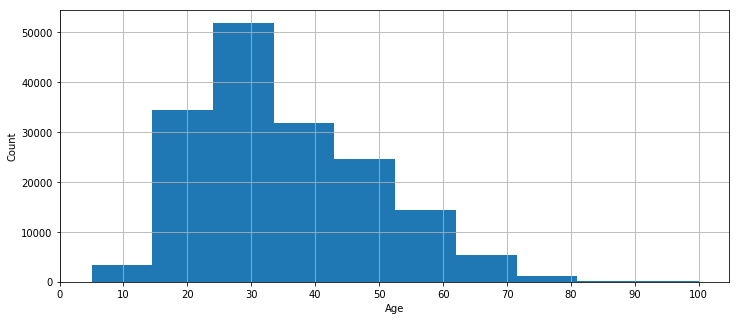

In [21]:
# We can also plot the Age distribution
ax = Users.Age.hist(bins=10, figsize=(12,5))
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_xticks(range(0,110,10))
plt.show()

We see that the most active users are in their 20–30s.

####  Books Dataset

We will explore Books dataset, firstly by checking its shape, first few columns and data types.

In [22]:
print(Books.shape)
print(list(Books.columns))
Books.head()

(271379, 8)
['ISBN', 'BookTitle', 'BookAuthor', 'YearofPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']


,ISBN,BookTitle,BookAuthor,YearofPublication,Publisher,ImageUrlS,ImageUrlM,ImageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [23]:
# We can see that image URLs columns do not seem to be required for analysis, and hence
# they will be dropped off.
Books.drop(columns=['ImageUrlS', 'ImageUrlM', 'ImageUrlL'], inplace=True)

In [24]:
# We now check the data types for each of the columns. 
Books.dtypes

ISBN                 object
BookTitle            object
BookAuthor           object
YearofPublication     int64
Publisher            object
dtype: object

In [25]:
# Check if there are any duplicate books.
Unique_Books = Books.ISBN.nunique()
All_Books = Books.ISBN.count()
print(f'Total book entries: {All_Books} | Unique book entries: {Unique_Books}')

Total book entries: 271379 | Unique book entries: 271379


In [26]:
## YearofPublication

# Check for 0's or NaNs in YearofPublication
Zero_Years = Books[Books.YearofPublication == 0].YearofPublication.count()
Nan_Years = Books.YearofPublication.isnull().sum()
print(f'YearofPublication: {Zero_Years} entries as \'0\' | {Nan_Years} NaN entries')

YearofPublication: 4619 entries as '0' | 0 NaN entries


In [111]:
# Replace all years of zero with NaN
Books.YearofPublication.replace(0, np.nan, inplace=True)

# YearofPublication unique values
print(sorted(Books.YearofPublication.unique()))

[1920.0, 1941.0, 1942.0, 1951.0, 1952.0, 1953.0, 1956.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1968.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, nan, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1909.0, 1910.0, 1911.0, 1914.0, 1917.0, 1919.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1954.0, 1955.0, 1957.0, 1967.0, 1969.0, 2005.0, 2006.0, 2008.0, 2010.0, 2011.0, 2012.0, 2020.0]


In [28]:
# It can be seen that YearofPublication has values ranging from 1376–2050. 
# There are books in the dataset with YearofPublication in the 1300s or in the future.

Books.groupby(["YearofPublication"]).size()

YearofPublication
1376.0        1
1378.0        1
1806.0        1
1897.0        1
1900.0        3
1901.0        7
1902.0        2
1904.0        1
1906.0        1
1908.0        1
1909.0        2
1910.0        1
1911.0       19
1914.0        1
1917.0        1
1919.0        1
1920.0       33
1921.0        2
1922.0        2
1923.0       11
1924.0        2
1925.0        2
1926.0        2
1927.0        2
1928.0        2
1929.0        7
1930.0       13
1931.0        3
1932.0        5
1933.0        4
          ...  
1989.0     7937
1990.0     8661
1991.0     9389
1992.0     9906
1993.0    10602
1994.0    11796
1995.0    13548
1996.0    14031
1997.0    14892
1998.0    15767
1999.0    17432
2000.0    17235
2001.0    17360
2002.0    17628
2003.0    14359
2004.0     5839
2005.0       46
2006.0        3
2008.0        1
2010.0        2
2011.0        2
2012.0        1
2020.0        3
2021.0        1
2024.0        1
2026.0        1
2030.0        7
2037.0        1
2038.0        1
2050.0        2
Length

In [29]:
# We have 1 book for each of 1376, 1378, 1806, 1897, 2021, 2024, 2026, 2037 and 2038 YearofPublication, 
# 7 with YearofPublication 2030 and 2 with YearofPublication 2050.

# As this dataset was built in 2004, and as there are only a few (18 in total) books with outliers
# in the YearofPublication, we will remove them from the Books table, as they may potentially skew the model.

Drop_Books = Books[ (Books.YearofPublication!=0) & ((Books.YearofPublication < 1900) | (Books.YearofPublication > 2020)) ] 
Books = Books.loc[~(Books.ISBN.isin(Drop_Books.ISBN))] 

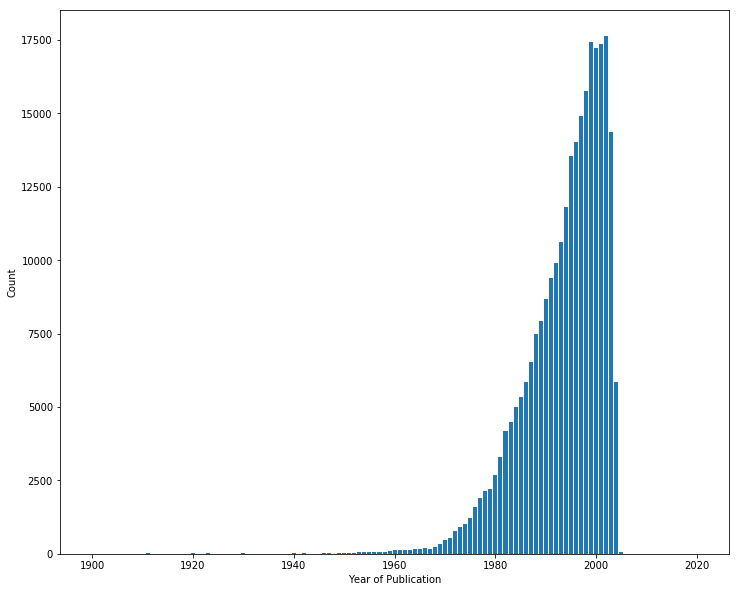

In [30]:
# We can also plot the YearofPublication distribution
Yrs = Books.YearofPublication.value_counts().sort_index()
plt.figure(figsize=(12, 10))
plt.bar(Yrs.index, Yrs.values)
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.show()

We see that more recent books are much more frequent.

In [31]:
## Publisher

# Search for empty or NaN values.
Empty_Publisher = Books[Books.Publisher == ''].Publisher.count()
Nan_Publisher = Books.Publisher.isnull().sum()
print(f'Publisher: {Empty_Publisher} empty entries | {Nan_Publisher} NaN entries')

Publisher: 0 empty entries | 2 NaN entries


Before going further, we need to clean up the Publisher data by replacing some ASCII characters with appropriate characters etc.

In [32]:
# First, we will clean up the ampersand formatting in the Publisher field.
Books.Publisher = Books.Publisher.str.replace('&amp;', '&', regex=False)
# Replace some ASCII characters with appropriate characters
Books.Publisher = Books.Publisher.apply(lambda x: strip_accents(x))
# Trim leading and/or trailing white spaces
Books = Books.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Capitalize First Letter
Books = Books.applymap(lambda x: string.capwords(x) if isinstance(x, str) else x)

In [33]:
# Find the 15 top Publishers
Top_Publishers = Books['Publisher'].value_counts()[:15]
print(f'The 15 publishers with the most entries are:\n{Top_Publishers}')         

The 15 publishers with the most entries are:
Harlequin                   7537
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3649
Harpercollins               3371
Scholastic                  3176
Simon & Schuster            2969
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Penguin Usa                 2716
Fawcett Books               2258
Signet Book                 2070
Random House Inc            2045
Name: Publisher, dtype: int64


In [34]:
## BookAuthor

# Search for empty or NaN values.
Empty_Author = Books[Books.BookAuthor == ''].BookAuthor.count()
Nan_Author = Books.BookAuthor.isnull().sum()
print(f'Author: {Empty_Author} empty entries | {Nan_Author} NaN entries')

Author: 0 empty entries | 1 NaN entries


Before going further, we need to clean up the BookAuthor data by replacing some ASCII characters with appropriate characters etc.

In [35]:
# Replace some ASCII characters with appropriate characters
Books.BookAuthor = Books.BookAuthor.apply(lambda x: strip_accents(x))
# Trim leading and/or trailing white spaces
Books = Books.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Replace not applicable (na ) strings with nan
Books = Books.replace({'not applicable (na )': np.nan}, regex=False)
# Capitalize First Letter
Books = Books.applymap(lambda x: string.capwords(x) if isinstance(x, str) else x)

In [36]:
# Find the 15 top Authors
Top_Authors = Books['BookAuthor'].value_counts()[:15]
print(f'The 15 authors with the most entries are:\n{Top_Authors}')          

The 15 authors with the most entries are:
Agatha Christie        636
William Shakespeare    572
Stephen King           534
Ann M. Martin          423
Francine Pascal        420
Carolyn Keene          373
Isaac Asimov           344
Nora Roberts           319
Barbara Cartland       308
Charles Dickens        307
R. L. Stine            282
Mark Twain             236
Jane Austen            230
Piers Anthony          222
Mary Higgins Clark     221
Name: BookAuthor, dtype: int64


In [37]:
## BookTitle

# Search for empty or NaN values.
Empty_Title = Books[Books.BookTitle == ''].BookTitle.count()
Nan_Title = Books.BookTitle.isnull().sum()
print(f'Title: {Empty_Title} empty entries | {Nan_Title} NaN entries')

Title: 0 empty entries | 0 NaN entries


In [38]:
# First, we will clean up the ampersand formatting in the BookTitle field.
Books.BookTitle = Books.BookTitle.str.replace('&amp;', '&', regex=False)
# Replace some ASCII characters with appropriate characters
Books.BookTitle = Books.BookTitle.apply(lambda x: strip_accents(x))
# Trim leading and/or trailing white spaces
Books = Books.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Capitalize First Letter
Books = Books.applymap(lambda x: string.capwords(x) if isinstance(x, str) else x)

In [39]:
# Find the 15 top Titles
Top_Titles = Books['BookTitle'].value_counts()[:15]
print(f'The 15 titles with the most entries are:\n{Top_Titles}') 

The 15 titles with the most entries are:
Selected Poems                    28
Little Women                      26
Dracula                           22
Wuthering Heights                 22
The Secret Garden                 21
The Night Before Christmas        20
Adventures Of Huckleberry Finn    20
Jane Eyre                         19
Pride And Prejudice               19
Great Expectations                17
Nemesis                           17
Masquerade                        16
Black Beauty                      16
Frankenstein                      16
Beloved                           15
Name: BookTitle, dtype: int64


We see that although the ISBN column has only unique values, there are many books with the same title.  
These may be books corresponding to a different version of the book.

In [40]:
# Let's investigate for example the top 1 title "Selected Poems".
Books[Books.BookTitle=='Selected Poems']

,ISBN,BookTitle,BookAuthor,YearofPublication,Publisher
4523,081120958x,Selected Poems,William Carlos Williams,1985.0,New Directions Publishing Corporation
29277,1875989927,Selected Poems,Jamie Grant,2001.0,Duffy & Snellgrove
39417,0811201465,Selected Poems,K. Patchen,1957.0,New Directions Publishing Corporation
41317,0679750800,Selected Poems,Rita Dove,1993.0,Vintage Books Usa
106890,0060931744,Selected Poems,Gwendolyn Brooks,1999.0,Perennial
118780,0517101548,Selected Poems,John Donne,1994.0,Gramercy Books
127468,0520012984,Selected Poems,Paul Verlaine,1970.0,University Of California Press
156902,0871401541,Selected Poems,E. E. Cummings,1994.0,Liveright Publishing Corporation
158321,0060909897,Selected Poems,Gwendolyn Brooks,1963.0,Harpercollins
175611,0571050190,Selected Poems,T. T Gunn,1962.0,Farrar Straus & Giroux


It looks like that for this book we have either different author or different publisher or different year of publication.  
Since our goal is to build a Book Recommender, our recommendations will be for a book, not a specific edition of a book.
So, later we will have to create a new field, where all the identical book-author cases would be considered as the same entry.


####  Ratings Dataset

We will explore Ratings dataset, firstly by checking its shape, first few columns and data types.

In [41]:
print(Ratings.shape)
print(list(Ratings.columns))
Ratings.head()

(1149780, 3)
['UserID', 'ISBN', 'BookRating']


,UserID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [42]:
# At Users dataset there are 278858 uniques UserIDs.
Unique_Users_Ratings = Ratings.UserID.nunique()
print(f'Unique user entries at Ratings Dataset: {Unique_Users_Ratings} | No of users that exist at Ratings Dataset but not at Users Dataset: {np.shape(Ratings)[0] - np.shape(Ratings[Ratings["UserID"].isin(Users["UserID"])])[0]}')

Unique user entries at Ratings Dataset: 105283 | No of users that exist at Ratings Dataset but not at Users Dataset: 0


In [43]:
# At Books dataset there are 271379 unique ISBNs.

Unique_Books_Ratings = Ratings.ISBN.nunique()
print(f'Unique book entries at Ratings Dataset: {Unique_Books_Ratings} | No of books that exist at Ratings Dataset but not at Books Dataset: {np.shape(Ratings)[0] - np.shape(Ratings[Ratings["ISBN"].isin(Books["ISBN"])])[0]}')

Unique book entries at Ratings Dataset: 340556 | No of books that exist at Ratings Dataset but not at Books Dataset: 203545


We have ratings for 340556 different book titles, which means that users have rated some books, which are not part of the Books dataset.   
We don't need those books, since we cannot recommend them.  
So, we will filter them out.

In [44]:
Ratings_New = Ratings[Ratings['ISBN'].isin(Books['ISBN'])]

Let's also check the sparsity of the dataset.  
Sparsity refers to the fact that many users only rate a small number of items and therefore the number of users that may have rated a particular item may be very small.

In [115]:
# Sparsity of the dataset can be calculated as below:
Sparsity = 1 - len(Ratings_New)/(float(Users.shape[0] * Books.shape[0]))
print(f'Sparsity Level: {Sparsity*100:.4f}%')

Sparsity Level: 99.9995%


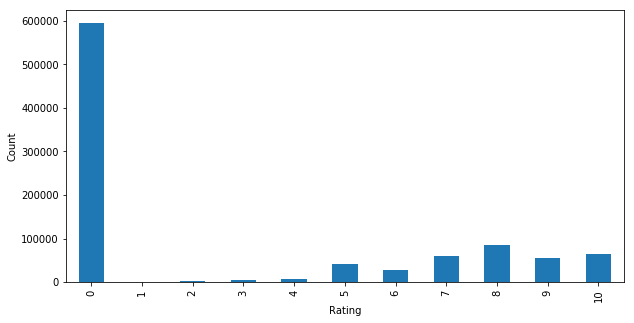

In [46]:
# Ratings Distribution
plt.figure(figsize=(10, 5))
Ratings_New.BookRating.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

We see that the vast majority of ratings are 0.  
The ratings of each user are either implicit (0) meaning the result of observed behavior, or explicit (1-10) meaning the user rated the book.  
For building our book recommendation system, we will use only explicit ratings, and so 0 rating entry rows will be removed.

In [47]:
Ratings_New = Ratings_New[Ratings_New.BookRating != 0]

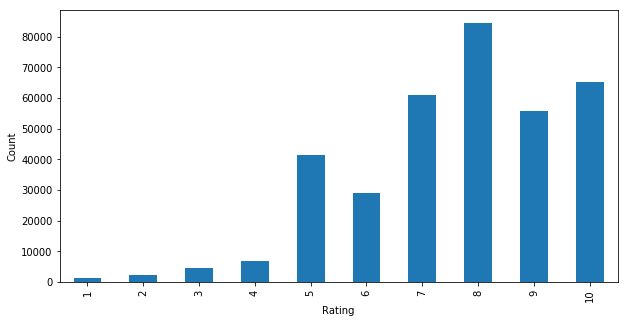

In [48]:
# Plot the Ratings Distribution again
plt.figure(figsize=(10, 5))
Ratings_New.BookRating.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [49]:
print(Ratings_New.BookRating.value_counts(sort=False))

1      1351
2      2183
3      4686
4      6983
5     41560
6     29078
7     61110
8     84335
9     55851
10    65240
Name: BookRating, dtype: int64


Now, it is clear that users tend to give high ratings (>=5) and 8 is the most frequent rating.

In [50]:
# Find the 15 top users that contributed most ratings
Top_Users_Ratings = Ratings_New.groupby('UserID').ISBN.count().sort_values(ascending=False)[:15]
print(f'The 15 users with the most ratings contribution are:\n{Top_Users_Ratings}')          

The 15 users with the most ratings contribution are:
UserID
11676     6354
98391     5234
189835    1712
153662    1652
23902     1082
235105     927
76499      926
171118     904
16795      878
248718     866
56399      772
197659     720
35859      706
185233     618
95359      540
Name: ISBN, dtype: int64


In [51]:
Users_No_Ratings = Ratings_New.groupby('UserID').ISBN.count().sort_values(ascending=False)

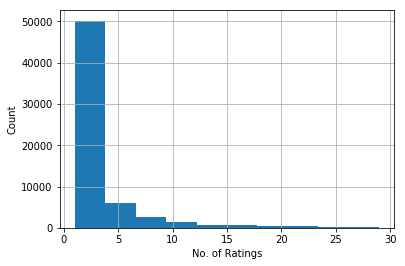

In [52]:
# Plot with users that have less than 30 ratings
user_hist = Users_No_Ratings.where(Users_No_Ratings<30)
user_hist.hist()
plt.xlabel('No. of Ratings')
plt.ylabel('Count')
plt.show()

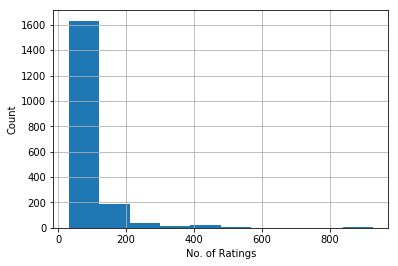

In [53]:
# Plot with users that have more than 30 ratings and less than 1000
user_hist = Users_No_Ratings.where((Users_No_Ratings > 30) & (Users_No_Ratings < 1000))
user_hist.hist()
plt.xlabel('No. of Ratings')
plt.ylabel('Count')
plt.show()

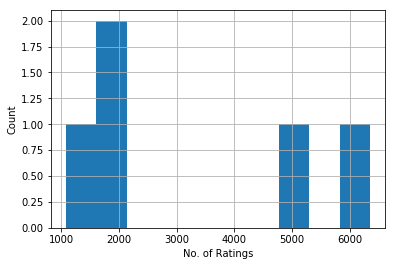

In [54]:
# Plot with users that have more than 1000 ratings
user_hist = Users_No_Ratings.where(Users_No_Ratings > 1000)
user_hist.hist()
plt.xlabel('No. of Ratings')
plt.ylabel('Count')
plt.show()

We see that the vast majority of users have rated only 1 or 2 books and the users that have more than 1000 ratings are rare.

#### Merge the Users Books, and Ratings tables

In [55]:
# First, we will join the Books and Ratings_New tables.
Books_with_Ratings = Ratings_New.join(Books.set_index('ISBN'), on='ISBN')
print(f'Books with Ratings table size: {len(Books_with_Ratings)} | Books table size: {len(Books)} | Ratings table size: {len(Ratings_New)}')

Books with Ratings table size: 352537 | Books table size: 271361 | Ratings table size: 352377


In [56]:
# Let's take a look at the new table.
Books_with_Ratings.head()

,UserID,ISBN,BookRating,BookTitle,BookAuthor,YearofPublication,Publisher
1,276726,0155061224,5,Rites Of Passage,Judith Rae,2001.0,Heinle
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (cambridge ...,Sue Leather,2001.0,Cambridge University Press
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,Harpertorch
19,276747,0671537458,9,Waiting To Exhale,Terry Mcmillan,1995.0,Pocket
20,276747,0679776818,8,Birdsong: A Novel Of Love And War,Sebastian Faulks,1997.0,Vintage Books Usa


In [57]:
Books_with_Ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352537 entries, 1 to 1149778
Data columns (total 7 columns):
UserID               352537 non-null int64
ISBN                 352537 non-null object
BookRating           352537 non-null int64
BookTitle            352537 non-null object
BookAuthor           352345 non-null object
YearofPublication    347187 non-null float64
Publisher            352537 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 21.5+ MB


We see that YearofPublication has some missing values.

In [58]:
# Find the 15 top books with the highest cumulative rating values.
Top_Cumulative_Rated_Books = Books_with_Ratings.groupby('BookTitle').BookRating.sum().sort_values(ascending=False)[:15]
print(f'The 15 books with the highest cumulative rating values are:\n{Top_Cumulative_Rated_Books}')  

The 15 books with the highest cumulative rating values are:
BookTitle
The Lovely Bones: A Novel                             5787
The Da Vinci Code                                     4169
The Secret Life Of Bees                               3432
The Red Tent (bestselling Backlist)                   3134
The Nanny Diaries: A Novel                            2923
Harry Potter And The Chamber Of Secrets (book 2)      2882
Life Of Pi                                            2619
Wild Animus                                           2551
Divine Secrets Of The Ya-ya Sisterhood: A Novel       2532
Harry Potter And The Prisoner Of Azkaban (book 3)     2505
Angels & Demons                                       2485
Where The Heart Is (oprah's Book Club (paperback))    2402
Girl With A Pearl Earring                             2392
To Kill A Mockingbird                                 2361
The Notebook                                          2314
Name: BookRating, dtype: int64


In [61]:
# Find the 15 top books with the highest average ratings (with > 30 received ratings).
Ratings_Received = Books_with_Ratings.BookTitle.value_counts()
Mean_Books_Ratings = Books_with_Ratings[Books_with_Ratings.BookTitle.isin(Ratings_Received[Ratings_Received>30].index)].groupby('BookTitle')['BookRating'].mean()
Top_Rated_Books = Mean_Books_Ratings.sort_values(ascending=False)[:15] 
print(f'The 15 books with the highest average ratings are:\n{Top_Rated_Books}')  

The 15 books with the highest average ratings are:
BookTitle
The Two Towers (the Lord Of The Rings, Part 2)            9.325758
The Return Of The King (the Lord Of The Rings, Part 3)    9.243478
The Grapes Of Wrath                                       9.129032
Harry Potter And The Goblet Of Fire (book 4)              9.125506
The Hobbit                                                9.120000
The Little Prince                                         9.111111
Charlotte's Web (trophy Newbery)                          9.073529
Griffin & Sabine: An Extraordinary Correspondence         9.062500
Love You Forever                                          9.055556
Illusions                                                 9.052632
84 Charing Cross Road                                     9.049180
Harry Potter And The Prisoner Of Azkaban (book 3)         9.043321
The Stand (the Complete And Uncut Edition)                9.025641
The Lord Of The Rings (movie Art Cover)                   9.024390
H

In [62]:
# Find the 15 books with the lowest average ratings (with > 30 received ratings).
Bottom_Rated_Books = Mean_Books_Ratings.sort_values(ascending=False)[-15:] 
print(f'The 15 books with the lowest average ratings are:\n{Bottom_Rated_Books}') 

The 15 books with the lowest average ratings are:
BookTitle
My Gal Sunday                                                               6.607843
Thousand Acres                                                              6.600000
Daddy                                                                       6.593750
Bleachers                                                                   6.583333
Portrait Of A Killer: Jack The Ripper -- Case Closed                        6.574468
Songs In Ordinary Time (oprah's Book Club (paperback))                      6.530303
One Hundred Years Of Solitude (oprah's Book Club)                           6.516129
The Sky Is Falling                                                          6.477273
The Little Friend                                                           6.272727
Sex & The City                                                              6.184211
Portrait Of A Killer: Jack The Ripper-- Case Closed (berkley True Crime)    6.121212
Violi

We see that the lowest average rating in the dataset is 4.39 and the rest of the books have an average rating higher than 5.

Now we will create a new field that will take into account books with the same title-author but with different editions.

In [63]:
Multiple_ISBNs = Books_with_Ratings.groupby(['BookTitle', 'BookAuthor']).ISBN.nunique() 
Multiple_ISBNs.value_counts()

1     119679
2       6521
3       1000
4        252
5         79
6         45
7         16
8         11
14         4
10         3
9          3
15         1
11         1
Name: ISBN, dtype: int64

We see that the vast majority of book titles have only 1 associated ISBN number, but there are some books that are associated with multiple ISBN numbers.

So, we will create a new field "Unique_ISBN", in order to have a single ISBN per book-author pair.  

In [64]:
Books_with_multiple_ISBNs = Multiple_ISBNs.where(Multiple_ISBNs > 1)
# Remove NaNs, which correspond to books associated with a single ISBN number
Books_with_multiple_ISBNs.dropna(inplace=True) 

Books_with_Ratings2 = Books_with_Ratings.drop_duplicates(['BookTitle', 'BookAuthor'])
Books_with_Ratings = pd.merge(Books_with_Ratings, Books_with_Ratings2,  how='left', left_on=['BookTitle','BookAuthor'], right_on = ['BookTitle','BookAuthor'], suffixes=['', '_r'])

# Drop the unnecessary columns
Books_with_Ratings = Books_with_Ratings.drop(['UserID_r', 'BookRating_r', 'YearofPublication_r', 'Publisher_r'], axis=1)
# Rename the new ISBN field
Books_with_Ratings = Books_with_Ratings.rename(columns = {'ISBN_r':'Unique_ISBN'})

Now, we will join the Books_with_Ratings and Users tables.

In [65]:
Books_Ratings_Users = Books_with_Ratings.join(Users.set_index('UserID'), on='UserID')
print(f'Books_Ratings_Users table size: {len(Books_Ratings_Users)} | Books_with_Ratings table size: {len(Books_with_Ratings)} | Users table size: {len(Users)}')

Books_Ratings_Users table size: 352537 | Books_with_Ratings table size: 352537 | Users table size: 278858


In [66]:
# Let's take a look at the new table.
Books_Ratings_Users.head()

,UserID,ISBN,BookRating,BookTitle,BookAuthor,YearofPublication,Publisher,Unique_ISBN,Age,City,State,Country
0,276726,0155061224,5,Rites Of Passage,Judith Rae,2001.0,Heinle,0155061224,NaN,Seattle,Washington,Usa
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (cambridge ...,Sue Leather,2001.0,Cambridge University Press,0521795028,16.0,Rijeka,NaN,Croatia
2,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,Harpertorch,0060517794,25.0,Iowa City,Iowa,Usa
3,276747,0671537458,9,Waiting To Exhale,Terry Mcmillan,1995.0,Pocket,0671537458,25.0,Iowa City,Iowa,Usa
4,276747,0679776818,8,Birdsong: A Novel Of Love And War,Sebastian Faulks,1997.0,Vintage Books Usa,0679776818,25.0,Iowa City,Iowa,Usa


In [67]:
Books_Ratings_Users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352537 entries, 0 to 352536
Data columns (total 12 columns):
UserID               352537 non-null int64
ISBN                 352537 non-null object
BookRating           352537 non-null int64
BookTitle            352537 non-null object
BookAuthor           352345 non-null object
YearofPublication    347187 non-null float64
Publisher            352537 non-null object
Unique_ISBN          352537 non-null object
Age                  246348 non-null float64
City                 344603 non-null object
State                333683 non-null object
Country              336522 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.0+ MB


There are some missing values in some fields, but we will handle them, if needed, later.

### Building a recommender system using collaborative filtering

In [68]:
# Create a new dataframe that contains the UserID, Unique_ISBN and BookRating columns.
User_Item_Rating = Books_Ratings_Users[['UserID', 'Unique_ISBN', 'BookRating']]

In [69]:
from surprise import Reader, Dataset

# First need to create a 'Reader' object to set the scale/limit of the ratings field
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'Dataset' object. The fields must be in the order: user, item, rating
data = Dataset.load_from_df(User_Item_Rating, reader)

# Load models and evaluation 
from surprise import SVD, NMF, CoClustering, model_selection, accuracy

# Using test-train split. Set test set to 20%.
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

Train the algorithms on the training set, and predict ratings for the test set.

In [70]:
models = []
models.append(('SVD', SVD()))
models.append(('NNMF', NMF()))
models.append(('Co-Clustering', CoClustering()))

# Evaluate each model
results = []
names = []

for name, model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions, verbose = False)
    model_summary = "%s - RMSE: %f" % (name, rmse)
    print(model_summary)
    results.append(rmse)
    names.append(name)

SVD - RMSE: 1.639926
NMF - RMSE: 2.465916
CoClustering - RMSE: 1.863068


Using cross-validation (5-folds):

In [71]:
# Load SVD algorithm
model = SVD()

# Evaluating RMSE of SVD on 5 folds.
model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6452  1.6394  1.6346  1.6371  1.6240  1.6361  0.0070  
Fit time          25.23   25.30   24.78   25.88   29.27   26.09   1.63    
Test time         1.14    0.84    0.76    0.89    0.89    0.91    0.13    


{'test_rmse': array([1.64518328, 1.6394169 , 1.63459827, 1.63713374, 1.62395607]),
 'fit_time': (25.229323387145996,
  25.299835205078125,
  24.776485204696655,
  25.88300323486328,
  29.26530957221985),
 'test_time': (1.1447608470916748,
  0.8385598659515381,
  0.762509822845459,
  0.8925967216491699,
  0.8935952186584473)}

The SVD model has an average RMSE of about 1.64 after 5-folds, with a fit time of about 26 sec for each fold.

Now, we will optimize the SVD algorithm, which has the best performance, with hyperparameter tuning, in order to improve the predictions even further.

In [73]:
from surprise.model_selection import GridSearchCV
 
param_grid = {'n_factors': [70, 80, 100, 120], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.01, 0.02, 0.04, 0.05]}

# Optimize SVD algorithm for both root mean squared error ('rmse') and mean average error ('mae')
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
    
# Fit the gridsearch result on the entire dataset (it takes a significant amount of time)
gs.fit(data)

print(f'Best RMSE Score: {gs.best_score["rmse"]} | Best parameters based on RMSE: {gs.best_params["rmse"]}')
print(f'Best MAE Score: {gs.best_score["mae"]} | Best parameters based on MAE: {gs.best_params["mae"]}')

Best RMSE Score: 1.630209213336417 | Best parameters based on RMSE: {'n_factors': 70, 'lr_all': 0.005, 'reg_all': 0.05}
Best MAE Score: 1.2593737816094015 | Best parameters based on MAE: {'n_factors': 70, 'lr_all': 0.005, 'reg_all': 0.05}


In [74]:
# Return the best version of the SVD algorithm based on RMSE
model = gs.best_estimator['rmse']

In [75]:
# Use the best hyperparameters for the training
model = SVD(n_factors=70, lr_all=0.005, reg_all=0.05)

model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions, verbose=False)

1.632798183301331

Using cross-validation (5-folds):

In [76]:
model_selection.cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6339  1.6261  1.6304  1.6324  1.6259  1.6297  0.0032  
MAE (testset)     1.2613  1.2605  1.2602  1.2610  1.2544  1.2595  0.0026  
Fit time          19.05   19.80   18.88   18.86   19.12   19.14   0.34    
Test time         1.08    0.76    1.06    1.06    0.77    0.95    0.15    


{'test_rmse': array([1.63389283, 1.62607751, 1.63044797, 1.632354  , 1.62591049]),
 'test_mae': array([1.26133648, 1.26047389, 1.26022557, 1.26096037, 1.25437729]),
 'fit_time': (19.049257516860962,
  19.80242609977722,
  18.881524562835693,
  18.859551429748535,
  19.115227222442627),
 'test_time': (1.0827202796936035,
  0.7615070343017578,
  1.0587072372436523,
  1.0647075176239014,
  0.7655096054077148)}

The SVD model has an average RMSE of about 1.63 after 5-folds, with a fit time of about 19 sec for each fold.

Using the optimized hyperparameters we see a slight improvement in the test RMSE compared with the unoptimized SVD algorithm.


Let's check some of the recommendations to see how accurate they are.  
For this purpose, we will choose a random user/book.

In [116]:
uid = 100644  
iid = '0001046438' # Unique_ISBN string

pred = model.predict(uid, iid, verbose = False)
Actual_Rating = User_Item_Rating[(User_Item_Rating.UserID==pred.uid) & (User_Item_Rating.Unique_ISBN==pred.iid)].BookRating.values[0]

print(f'The predicted rating for the book with the Unique_ISBN code {pred.iid} from User {pred.uid} is {pred.est:.2f}.')
print(f'The real rating given for this book was {Actual_Rating:.2f}.')

The predicted rating for the book with the Unique_ISBN code 0001046438 from User 100644 is 7.74.
The real rating given for this book was 7.00.


In [117]:
uid = 108997  
iid = '0002242591' # Unique_ISBN string

pred = model.predict(uid, iid, verbose = False)
Actual_Rating = User_Item_Rating[(User_Item_Rating.UserID==pred.uid) & (User_Item_Rating.Unique_ISBN==pred.iid)].BookRating.values[0]

print(f'The predicted rating for the book with the Unique_ISBN code {pred.iid} from User {pred.uid} is {pred.est:.2f}.')
print(f'The real rating given for this book was {Actual_Rating:.2f}.')

The predicted rating for the book with the Unique_ISBN code 0002242591 from User 108997 is 7.89.
The real rating given for this book was 8.00.


We can also find the top-N recommendations for each user.

In [81]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n



def get_reading_list(userid):
    """
    Retrieve full book titles from 'Books_Ratings_Users' dataframe
    """
    reading_list = defaultdict(list)
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = Books_Ratings_Users.loc[Books_Ratings_Users.Unique_ISBN==book].BookTitle.unique()[0]
        reading_list[title] = rating
    return reading_list



# Get the top 10 recommended books for each UserID in the test set.
pred = model.test(testset)
top_n = get_top_n(pred)

In [83]:
# Choose a random user
Example_Reading_List = get_reading_list(userid=6251)
for book, rating in Example_Reading_List.items():
    print(f'{book}: {rating}')

Lamb : The Gospel According To Biff, Christ's Childhood Pal: 9.289423444326586
The Phantom Tollbooth: 9.16135203857356
The Neverending Story: 9.069542981987327
One For The Money (stephanie Plum Novels (paperback)): 8.863830722439916
The New Joy Of Cooking: 8.764036084166435
A Soldier Of The Great War: 8.761300899384201
Stuart Little: 8.749615889172853
All I Know About Animal Behavior I Learned In Loehmann's Dressing Room: 8.728406514534502
The Dollmaker: 8.72164738981785
Ain't I A Woman!: A Book Of Women's Poetry From Around The World: 8.699623992894178


The actual ratings given by this user were:  
Lamb : The Gospel According To Biff, Christ's Childhood Pal: 10  
The Phantom Tollbooth: 10  
The Neverending Story: 10
One For The Money (stephanie Plum Novels (paperback)): 10  
The New Joy Of Cooking: 10  
A Soldier Of The Great War: 7  
Stuart Little: 10  
All I Know About Animal Behavior I Learned In Loehmann's Dressing Room: 9  
The Dollmaker: 10  
Ain't I A Woman!: A Book Of Women's Poetry From Around The World: 9    

We can also create a data frame with all the predictions.

In [84]:
def get_No_Items_by_User(uid):
    """ Return the number of items rated by a given user
    Args: 
      uid: the id of the user
    Returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_No_Users_rated_Item(iid):
    """ Return number of users that have rated a given item
    Args:
      iid: the id of the item
    Returns:
      the number of users that have rated the item
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'Actual_Rating', 'Predicted_Rating', 'Details'])
df['No_Items_by_User'] = df.uid.apply(get_No_Items_by_User)
df['No_Users_rated_Item'] = df.iid.apply(get_No_Users_rated_Item)
df['Error'] = abs(df.Predicted_Rating - df.Actual_Rating)

So, let's examine the 10 best predictions and the 10 worst predictions.

In [85]:
# Best Predictions
Best_Predictions = df.sort_values(by='Error')[:10]
print(Best_Predictions)

          uid         iid  Actual_Rating  Predicted_Rating  \
12620  274061  0505523728           10.0              10.0   
31499   31826  0380018179           10.0              10.0   
8527   156111  1591160650           10.0              10.0   
30254  153662  0439136369           10.0              10.0   
3784   182086  0373153260           10.0              10.0   
33362  274061  0689711522           10.0              10.0   
56282  182086  0373291418           10.0              10.0   
41755   44252  0451524934           10.0              10.0   
33497  141902  0842329218           10.0              10.0   
24048  254206  0395177111           10.0              10.0   

                         Details  No_Items_by_User  No_Users_rated_Item  Error  
12620  {'was_impossible': False}               154                   11    0.0  
31499  {'was_impossible': False}               299                   64    0.0  
8527   {'was_impossible': False}                62                    7   

In [86]:
# Worst Predictions
Worst_Predictions = df.sort_values(by='Error')[-10:] 
print(Worst_Predictions)

          uid         iid  Actual_Rating  Predicted_Rating  \
58747   76499  0816628017            1.0          8.781223   
32369   76499  0674298748            1.0          8.781223   
12238   76499  0156701537            1.0          8.781223   
41829   76499  0324041594            1.0          8.781223   
57752   51883  0373224672            1.0          8.868199   
48680  208907  0890811156            1.0          9.315119   
39221  208907  0130563927            1.0          9.315119   
13881  157811  0060392452            1.0          9.564465   
55757  138883  0671000853            1.0          9.570263   
32586   76499  0684804484            1.0          9.650115   

                         Details  No_Items_by_User  No_Users_rated_Item  \
58747  {'was_impossible': False}               748                    0   
32369  {'was_impossible': False}               748                    0   
12238  {'was_impossible': False}               748                    0   
41829  {'was_impo

Let’s look in more detail the worst prediction for the book with ISBN "0684804484". 
The book was rated by 3 users, user "76499" rated 1 and SVD algorithm predicts this user would rate 9.650115.

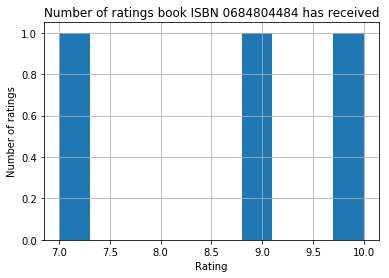

In [95]:
Books_Ratings_Users.loc[(Books_Ratings_Users['Unique_ISBN'] == '0684804484') & (Books_Ratings_Users['UserID']!= 76499)]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0684804484 has received')
plt.show()

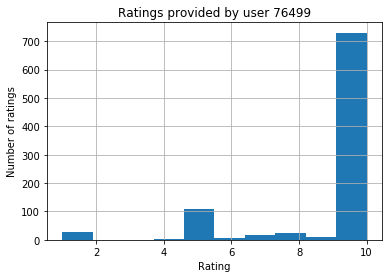

In [103]:
Books_Ratings_Users.loc[Books_Ratings_Users['UserID']== 76499]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Ratings provided by user 76499')
plt.show()

It turns out that other users provided much higher ratings than user 76499. Also, the average rating of this user is 8.96 with only very few ratings below 5.  
  
Let’s also check the book "0671000853". The book was rated by 26 users, user "138883" rated 1 and SVD algorithm predicts this user would rate 9.570263.

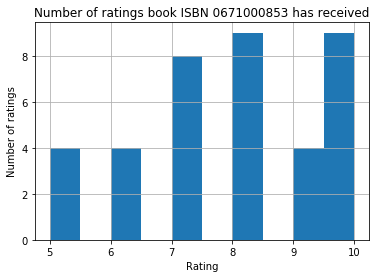

In [97]:
Books_Ratings_Users.loc[(Books_Ratings_Users['Unique_ISBN'] == '0671000853') & (Books_Ratings_Users['UserID']!= 138883)]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0671000853 has received')
plt.show()

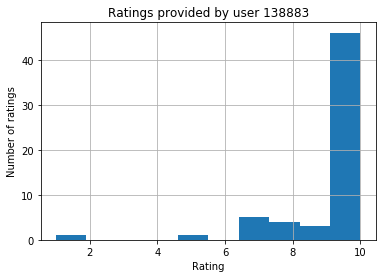

In [104]:
Books_Ratings_Users.loc[Books_Ratings_Users['UserID']== 138883]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Ratings provided by user 138883')
plt.show()

We see that all other users rated this book with much higher values. Also, the average rating of this user is 9.33 with only 2 ratings below 5.  
  
Let’s also check the book "0060392452". The book was rated by 128 users, user "157811" rated 1 and SVD algorithm predicts this user would rate 9.564465.

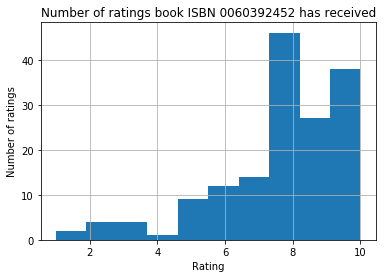

In [98]:
Books_Ratings_Users.loc[(Books_Ratings_Users['Unique_ISBN'] == '0060392452') & (Books_Ratings_Users['UserID']!= 157811)]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 0060392452 has received')
plt.show()            

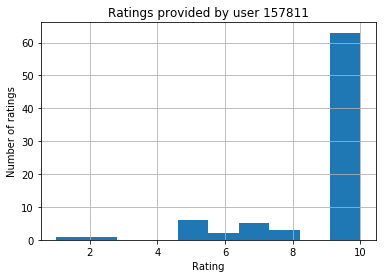

In [107]:
Books_Ratings_Users.loc[Books_Ratings_Users['UserID']== 157811]['BookRating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Ratings provided by user 157811')
plt.show()

It turns out that most of the users in the data rated this book with high values, and only very few users gave ratings below 5. Also, the average rating of this user is 9.06 with very few ratings below 5.